## [Global Terrorism Database](https://www.start.umd.edu/gtd/)

#### We will move with:

- We will first explore the dataset and try to understand it with visualizations. <br/>

- Will fix the dataset with: imputing missing values in the important columns, removing redundant information, droping the less important infromation etc.

- Then using attack type, weapons used, description of the attack, etc., will build a prediction model that can predict what group may be behind an incident.


In [373]:
# Dependencies

import math, os
import numpy as np
import pandas as pd
import random
import time

import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline 

In [203]:
params = {'legend.fontsize': 'xx-small',
         'axes.labelsize': 'xx-small',
         'axes.titlesize':'xx-small',
         'xtick.labelsize':'xx-small',
         'ytick.labelsize':'xx-small'}
plt.rcParams.update(params)

The data can be downloaded from the database [website](https://www.start.umd.edu/gtd/). The database contains few csv files with data from different time span splitted into separate files. Here, we look into the one of the files with terrorist incidents occuring between 1995 to 2012.

In [204]:
# Importing the data as pandas DataFrame

df = pd.read_excel("gtd_95to12_0617dist.xlsx", sheetname=0)

# renaming date time to change type into timestamp later
df = df.rename(columns={'iyear': 'year', 'imonth': 'month', 'iday': 'day'})

In [205]:
# word_tokenize(str(df['summary'].loc[55051].split()))
df['day'][df.day == 0] = 1
df['date'] = pd.to_datetime(df[['day', 'month', 'year']])

df.head()

/home/rabindra/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


,eventid,year,month,day,approxdate,extended,resolution,country,country_txt,region,...,scite1,scite2,scite3,dbsource,INT_LOG,INT_IDEO,INT_MISC,INT_ANY,related,date
0,199501000001,1995,1,1,NaN,0,NaT,217,United States,1,...,NaN,NaN,NaN,PGIS,-9,-9,0,-9,"199501000001, 199501000002, 199501000003",1995-01-01
1,199501000002,1995,1,1,NaN,0,NaT,217,United States,1,...,NaN,NaN,NaN,PGIS,-9,-9,0,-9,"199501000002, 199501000001, 199501000003",1995-01-01
2,199501000003,1995,1,1,NaN,0,NaT,217,United States,1,...,NaN,NaN,NaN,PGIS,-9,-9,0,-9,"199501000003, 199501000001, 199501000002",1995-01-01
3,199501010001,1995,1,1,NaN,0,NaT,202,Tajikistan,7,...,NaN,NaN,NaN,PGIS,-9,-9,1,1,NaN,1995-01-01
4,199501010002,1995,1,1,NaN,0,NaT,209,Turkey,10,...,NaN,NaN,NaN,PGIS,-9,-9,1,1,NaN,1995-01-01


In [206]:
df.columns

Index(['eventid', 'year', 'month', 'day', 'approxdate', 'extended',
       'resolution', 'country', 'country_txt', 'region',
       ...
       'scite1', 'scite2', 'scite3', 'dbsource', 'INT_LOG', 'INT_IDEO',
       'INT_MISC', 'INT_ANY', 'related', 'date'],
      dtype='object', length=136)

In [207]:
# missing values: NaN values in the data

def missing_values():
    temp_dict = dict()
    for i in df.columns:
        if df[i].isnull().sum() > 0: 
            temp_dict[i] = df[i].isnull().sum()
    return temp_dict

# gives the information of missing values in each of the decorations
len(missing_values())

104

#### Removing the columns that contain more than half of the missing values

Let us not even look what the columns are for if they are already missing more than half of the data points missing. The imputation of the missing values in such case might be difficult and missleading. 

In [208]:
# First DROPPING the columns that contain more than 50% of its data NaNs

def delete_columns(col):
    if df[col].isnull().sum() > df[col].count()/2:
        del df[col]

for col in df.columns:
    delete_columns(col)

In [209]:
df.head(n=5)

,eventid,year,month,day,extended,country,country_txt,region,region_txt,provstate,...,nwoundte,property,ishostkid,scite1,dbsource,INT_LOG,INT_IDEO,INT_MISC,INT_ANY,date
0,199501000001,1995,1,1,0,217,United States,1,North America,New Mexico,...,NaN,1,0.0,NaN,PGIS,-9,-9,0,-9,1995-01-01
1,199501000002,1995,1,1,0,217,United States,1,North America,New Mexico,...,NaN,1,0.0,NaN,PGIS,-9,-9,0,-9,1995-01-01
2,199501000003,1995,1,1,0,217,United States,1,North America,New Mexico,...,NaN,1,0.0,NaN,PGIS,-9,-9,0,-9,1995-01-01
3,199501010001,1995,1,1,0,202,Tajikistan,7,Central Asia,NaN,...,NaN,0,0.0,NaN,PGIS,-9,-9,1,1,1995-01-01
4,199501010002,1995,1,1,0,209,Turkey,10,Middle East & North Africa,Istanbul,...,NaN,1,0.0,NaN,PGIS,-9,-9,1,1,1995-01-01


In [210]:
# these are the columns left with us now
df.columns, print(df.columns.shape)

(58,)


(Index(['eventid', 'year', 'month', 'day', 'extended', 'country', 'country_txt',
        'region', 'region_txt', 'provstate', 'city', 'latitude', 'longitude',
        'specificity', 'vicinity', 'summary', 'crit1', 'crit2', 'crit3',
        'doubtterr', 'multiple', 'success', 'suicide', 'attacktype1',
        'attacktype1_txt', 'targtype1', 'targtype1_txt', 'targsubtype1',
        'targsubtype1_txt', 'corp1', 'target1', 'natlty1', 'natlty1_txt',
        'gname', 'motive', 'guncertain1', 'individual', 'nperpcap', 'claimed',
        'weaptype1', 'weaptype1_txt', 'weapsubtype1', 'weapsubtype1_txt',
        'nkill', 'nkillus', 'nkillter', 'nwound', 'nwoundus', 'nwoundte',
        'property', 'ishostkid', 'scite1', 'dbsource', 'INT_LOG', 'INT_IDEO',
        'INT_MISC', 'INT_ANY', 'date'],
       dtype='object'), None)

In [211]:
imp_columns = {'eventid', 'year', 'month', 'day', 'date', 'country', 'country_txt', 'region_txt', 'provstate', 'city', 
              'latitude', 'longitude', 'summary', 'crit1', 'success', 'suicide', 'attacktype1_txt', 'targtype1_txt', 
              'gname', 'motive', 'claimed', 'weaptype1_txt', 'nkill', 'nkillus', 'nkillter', 'nwound', 'nwoundus', 
              'nwoundte'}

In [212]:
data_frame = pd.DataFrame(df, columns=imp_columns)
data_frame.head()

,country,country_txt,eventid,year,nwound,nkillus,provstate,suicide,nkillter,crit1,...,date,nkill,attacktype1_txt,latitude,longitude,summary,motive,nwoundus,gname,day
0,217,United States,199501000001,1995,0.0,NaN,New Mexico,0,NaN,1,...,1995-01-01,0.0,Facility/Infrastructure Attack,35.084180,-106.648639,NaN,NaN,NaN,Anti-Abortion extremists,1
1,217,United States,199501000002,1995,0.0,NaN,New Mexico,0,NaN,1,...,1995-01-01,0.0,Facility/Infrastructure Attack,35.084180,-106.648639,NaN,NaN,NaN,Anti-Abortion extremists,1
2,217,United States,199501000003,1995,0.0,NaN,New Mexico,0,NaN,1,...,1995-01-01,0.0,Facility/Infrastructure Attack,35.084180,-106.648639,NaN,NaN,NaN,Anti-Abortion extremists,1
3,202,Tajikistan,199501010001,1995,0.0,NaN,NaN,0,NaN,1,...,1995-01-01,10.0,Assassination,38.536667,68.780000,NaN,NaN,NaN,Unknown,1
4,209,Turkey,199501010002,1995,0.0,NaN,Istanbul,0,NaN,1,...,1995-01-01,0.0,Bombing/Explosion,41.013517,28.950672,NaN,NaN,NaN,Unknown,1


In [213]:
data_frame[data_frame.crit1==0].shape

(820, 28)

In [214]:
# if crit1 == 0: then the events recorded might not be the actual terrorist activity

data_frame[(data_frame.crit1 == 0) & ((data_frame.gname =='Gunmen')|(data_frame.gname == 'Unknown'))].shape

(735, 28)

In [215]:
# Now we are left with these NaNs
# We need to engineer these missing values if we want to use these columns for 
# prediction model development later

missing_values()

{'city': 446,
 'claimed': 9260,
 'corp1': 14327,
 'guncertain1': 379,
 'ishostkid': 3,
 'latitude': 1033,
 'longitude': 1033,
 'motive': 16024,
 'natlty1': 427,
 'natlty1_txt': 427,
 'nkill': 835,
 'nkillter': 10364,
 'nkillus': 9435,
 'nperpcap': 12624,
 'nwound': 2499,
 'nwoundte': 11117,
 'nwoundus': 9626,
 'provstate': 2598,
 'scite1': 9325,
 'specificity': 4,
 'summary': 9263,
 'target1': 238,
 'targsubtype1': 3024,
 'targsubtype1_txt': 3024,
 'weapsubtype1': 5305,
 'weapsubtype1_txt': 5305}

## NaNs Imputation

Out of the remaining columns with missing values listed above, we will take into account only few of the important columns and impute the missing values on those columns.

In [216]:
data_frame['claimed'].unique()

array([ nan,   0.,  -9.,   1.])

The claimed has only three unique values: 0: Not claimed, 1: claimed and -9: Unknown

If the value is missing we assume that the incident was not claimed ie. NaN => 0.

In [217]:
data_frame['claimed'] = data_frame['claimed'].fillna(0)

In [218]:
data_frame['claimed'].unique()

array([ 0., -9.,  1.])

Let us see the missing values in the 'city' and 'longitdue' columns.
'latitude' and 'longitude' if missing are both missing for the same events.

In [219]:
data_frame[data_frame['city'].isnull()].shape[0], data_frame[data_frame['longitude'].isnull()].shape[0]

(446, 1033)

The number of incidents that miss both 'city' and 'longitude' informations.

In [220]:
tmp_list = ['country_txt', 'region_txt', 'city', 'longitude', 'latitude']

data_frame[tmp_list][data_frame['latitude'].isnull() & data_frame['city'].isnull()].shape

(17, 5)

Since only 17 of the events miss both of the city and longitude information simultaneously. We we reciprocate the 'city' and 'latitude/longitude' missing values from each other columns. Those 17 events which miss both can be dropped.

In [221]:
rows_missing_both_city_coords = data_frame[['city', 'latitude', 'longitude']][data_frame['latitude'].isnull() & 
                                data_frame['city'].isnull()].index.tolist()

# the new df ahead will not contain those 17 events: dropping those events 
data_frame = data_frame.drop(rows_missing_both_city_coords)

In [222]:
all_cities = data_frame['city'].unique().tolist()
all_cities[:10]

['Albuquerque',
 'Dushanbe',
 'Istanbul',
 'Copenhagen',
 'Guatemala City',
 'Unknown',
 'Hebron',
 'Tbeng Rhpuos Kam Pong Chnnang Province',
 'Mallawi',
 'Assisi']

In [22]:
data_frame[['city', 'longitude', 'latitude']].head()

,city,longitude,latitude
0,Albuquerque,-106.648639,35.084180
1,Albuquerque,-106.648639,35.084180
2,Albuquerque,-106.648639,35.084180
3,Dushanbe,68.780000,38.536667
4,Istanbul,28.950672,41.013517


In [223]:
data_frame.shape

(55038, 28)

In [224]:
# storing the mode 'latitude' and 'longitude' values of each city: i.e. the most frequent value of the coordinates
# from the known values corresponding to the events occuring in the same city

city_coords_dict = dict()

for city in all_cities:
    long = float(data_frame['longitude'][data_frame['city'] == city].median())
    lat = float(data_frame['latitude'][data_frame['city'] == city].median())
    city_coords_dict[city] = [long, lat]

In [225]:
# equal number of events missing latitude and longitude => same events missing both?

print(data_frame[data_frame['longitude'].isnull()==True]['country_txt'].shape)
print(data_frame[data_frame['latitude'].isnull()==True]['country_txt'].shape)

(1016,)
(1016,)


## Plotting incidents place in the world map

In [226]:
# Import the basemap package
from mpl_toolkits.basemap import Basemap
from IPython.display import set_matplotlib_formats
from mpl_toolkits import basemap

# Turn on retina display mode
set_matplotlib_formats('retina')
# turn off interactive mode
plt.ioff()

In [227]:
# printing the all possible projections for the earth(sphere) to 2D plane map projections
print(basemap.supported_projections)

 cyl              Cylindrical Equidistant                 
 merc             Mercator                                
 tmerc            Transverse Mercator                     
 omerc            Oblique Mercator                        
 mill             Miller Cylindrical                      
 gall             Gall Stereographic Cylindrical          
 cea              Cylindrical Equal Area                  
 lcc              Lambert Conformal                       
 laea             Lambert Azimuthal Equal Area            
 nplaea           North-Polar Lambert Azimuthal           
 splaea           South-Polar Lambert Azimuthal           
 eqdc             Equidistant Conic                       
 aeqd             Azimuthal Equidistant                   
 npaeqd           North-Polar Azimuthal Equidistant       
 spaeqd           South-Polar Azimuthal Equidistant       
 aea              Albers Equal Area                       
 stere            Stereographic                         

/home/rabindra/anaconda3/lib/python3.6/site-packages/mpl_toolkits/basemap/__init__.py:1623: MatplotlibDeprecationWarning: The get_axis_bgcolor function was deprecated in version 2.0. Use get_facecolor instead.
  fill_color = ax.get_axis_bgcolor()
/home/rabindra/anaconda3/lib/python3.6/site-packages/mpl_toolkits/basemap/__init__.py:1767: MatplotlibDeprecationWarning: The get_axis_bgcolor function was deprecated in version 2.0. Use get_facecolor instead.
  axisbgc = ax.get_axis_bgcolor()
/home/rabindra/anaconda3/lib/python3.6/site-packages/mpl_toolkits/basemap/__init__.py:3260: MatplotlibDeprecationWarning: The ishold function was deprecated in version 2.0.
  b = ax.ishold()
/home/rabindra/anaconda3/lib/python3.6/site-packages/mpl_toolkits/basemap/__init__.py:3269: MatplotlibDeprecationWarning: axes.hold is deprecated.
    See the API Changes document (http://matplotlib.org/api/api_changes.html)
    for more details.
  ax.hold(b)


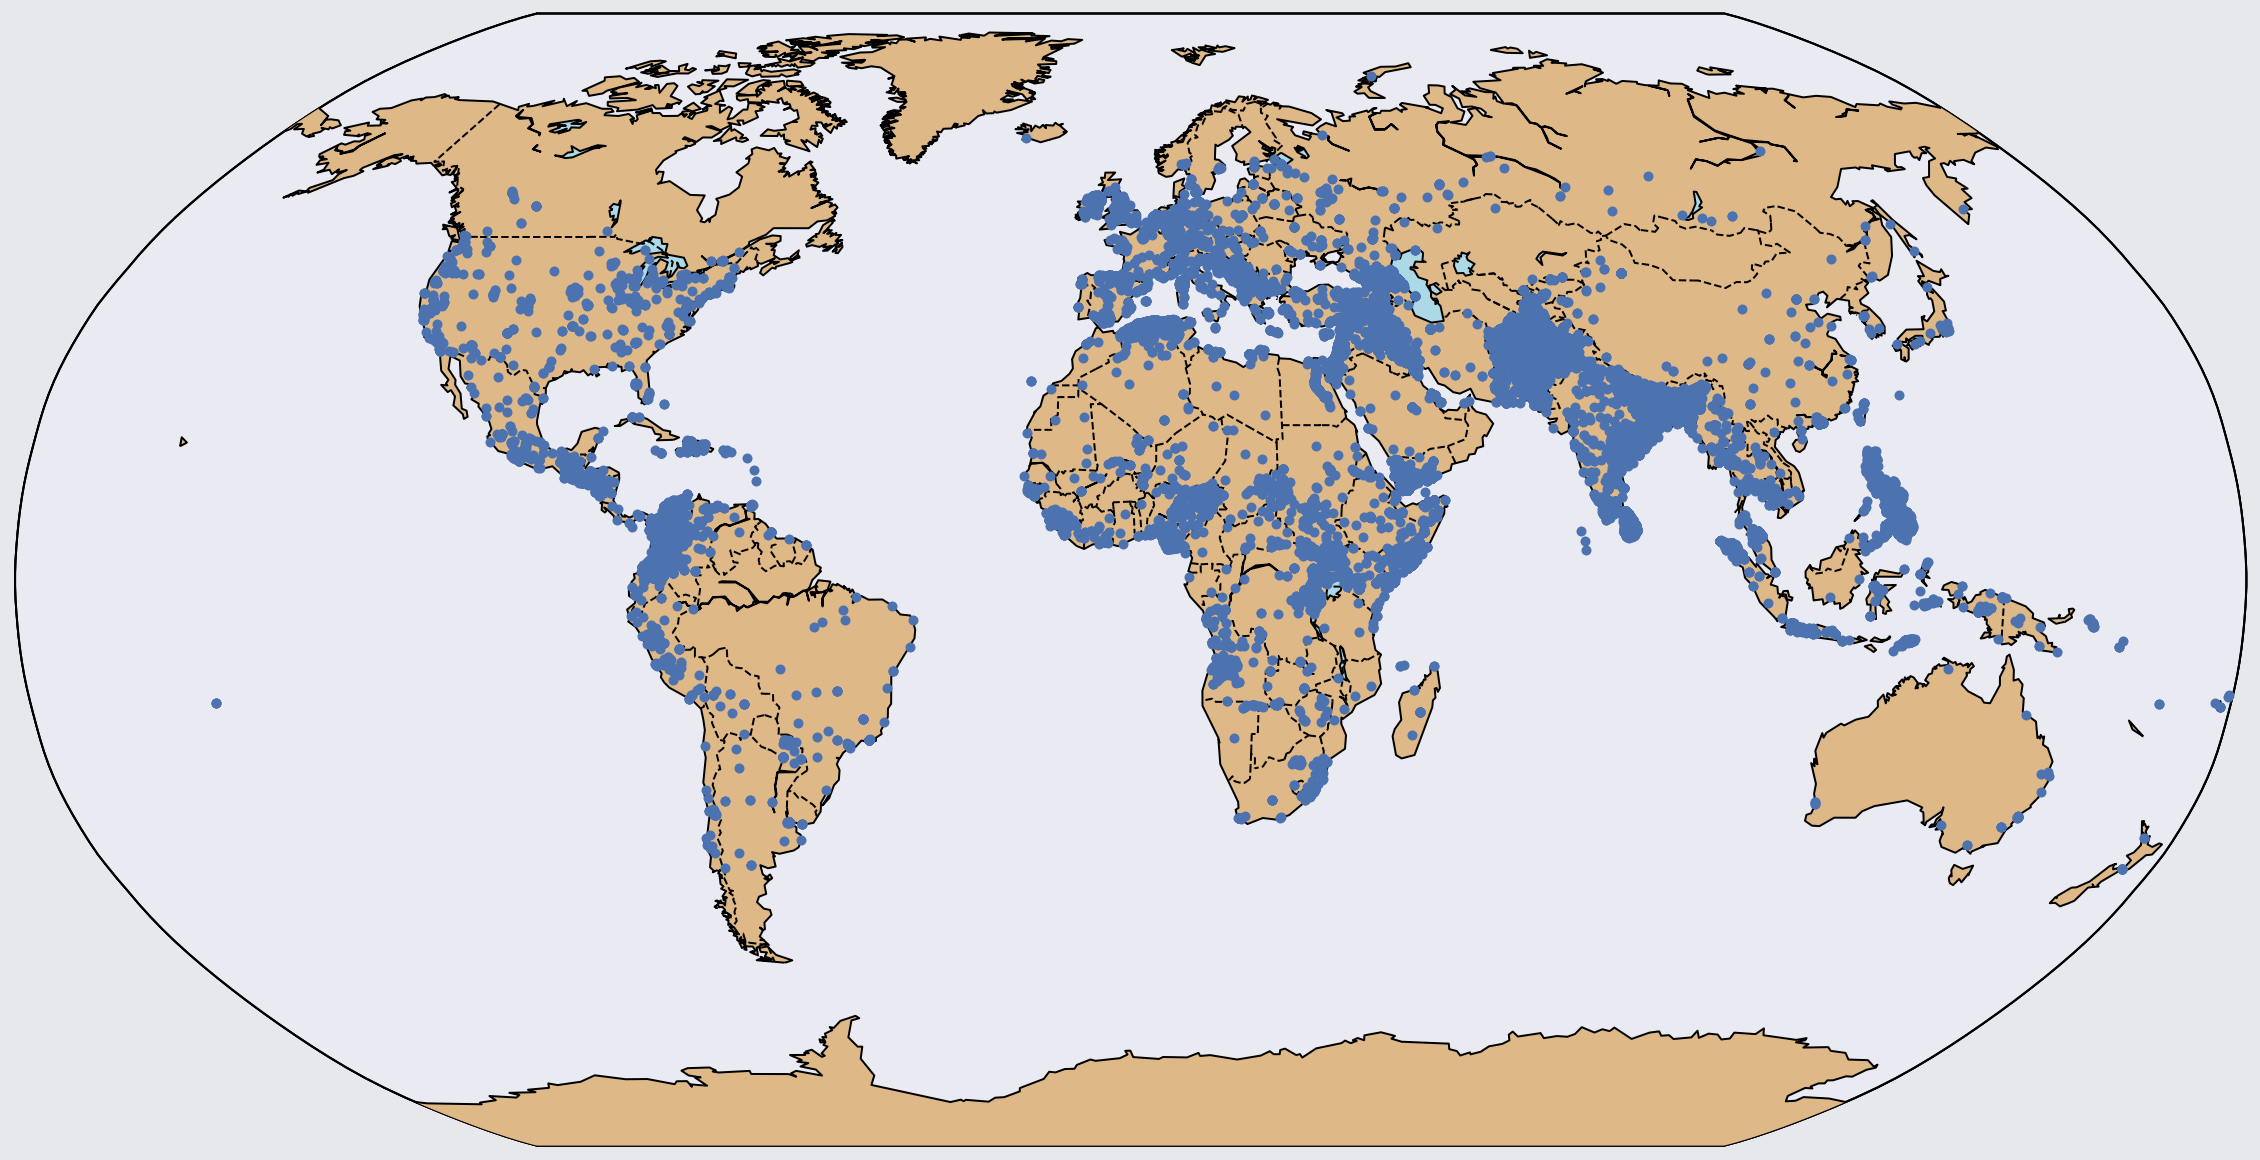

In [228]:
# Plotting the incidents locations in the map

fig = plt.figure(figsize=(20,15))
m = Basemap(projection='robin', lon_0=0)

# background color of the map - greyish color
fig.patch.set_facecolor('#e6e8ec')

#m.drawmapboundary(fill_color='aqua')

# Draw coastlines, and the edges of the map.
m.drawcoastlines(color='black')
m.fillcontinents(color='burlywood', lake_color='lightblue')
m.drawcountries(linewidth=1, linestyle='dashed' ,color='black')
m.drawmapboundary(fill_color='lightblue')

graticule_width = 20
graticule_color = 'white'

m.drawmapboundary()

# Convert latitude and longitude to x and y coordinates
xs = list(data_frame['longitude'].astype(float))
ys = list(data_frame['latitude'].astype(float))

num_killed = list(data_frame['nkill'].astype(float))

x, y = m(xs, ys)
m.plot(x, y, "o", markersize=5, alpha=1)
plt.show()

In [229]:
data_frame['weaptype1_txt'].unique()

array(['Incendiary', 'Chemical', 'Explosives/Bombs/Dynamite', 'Unknown',
       'Firearms', 'Melee', 'Fake Weapons', 'Other', 'Sabotage Equipment',
       'Vehicle (not to include vehicle-borne explosives, i.e., car or truck bombs)',
       'Biological', 'Radiological'], dtype=object)

In [230]:
data_frame['attacktype1_txt'].unique()

array(['Facility/Infrastructure Attack', 'Assassination',
       'Bombing/Explosion', 'Unknown', 'Armed Assault', 'Hijacking',
       'Hostage Taking (Kidnapping)', 'Unarmed Assault',
       'Hostage Taking (Barricade Incident)'], dtype=object)

In [231]:
data_frame['targtype1_txt'].unique().shape

(22,)

In [232]:
# In Nepal
in_nepal = data_frame.loc[data_frame['country_txt']=='Nepal']
# Total number of people killed in Nepal
in_nepal['nkill'].sum()

1941.0

In [233]:
countries_list = df['country_txt'].unique().tolist()
countries_list
country_killed = dict()

for country in countries_list:
    tmp_df = df.loc[df['country_txt']==country]
    num_killed = tmp_df['nkill'].sum()
    country_killed[country] = num_killed

In [234]:
sorted_country_killed_dict = sorted(country_killed.items(), key= lambda x: x[1], reverse=True)
num_killed_list = [x[1] for x in sorted_country_killed_dict if x[1] > 1500]
corresponding_countries_list = [x[0] for x in sorted_country_killed_dict if x[1] > 1500]

In [235]:
# country name and number of people killed in each country
list(filter(lambda x: x[1] > 1500, sorted_country_killed_dict))

[('Iraq', 29589.0),
 ('Pakistan', 13307.0),
 ('Afghanistan', 11366.0),
 ('India', 10344.0),
 ('Algeria', 10142.0),
 ('Sri Lanka', 6027.0),
 ('Colombia', 5588.0),
 ('Russia', 3878.0),
 ('Burundi', 3436.0),
 ('United States', 3239.0),
 ('Nigeria', 3190.0),
 ('Somalia', 2950.0),
 ('Philippines', 2596.0),
 ('Sudan', 2191.0),
 ('Yemen', 2111.0),
 ('Uganda', 2079.0),
 ('Democratic Republic of the Congo', 2045.0),
 ('Nepal', 1941.0),
 ('Angola', 1767.0),
 ('Thailand', 1662.0),
 ('Rwanda', 1515.0)]

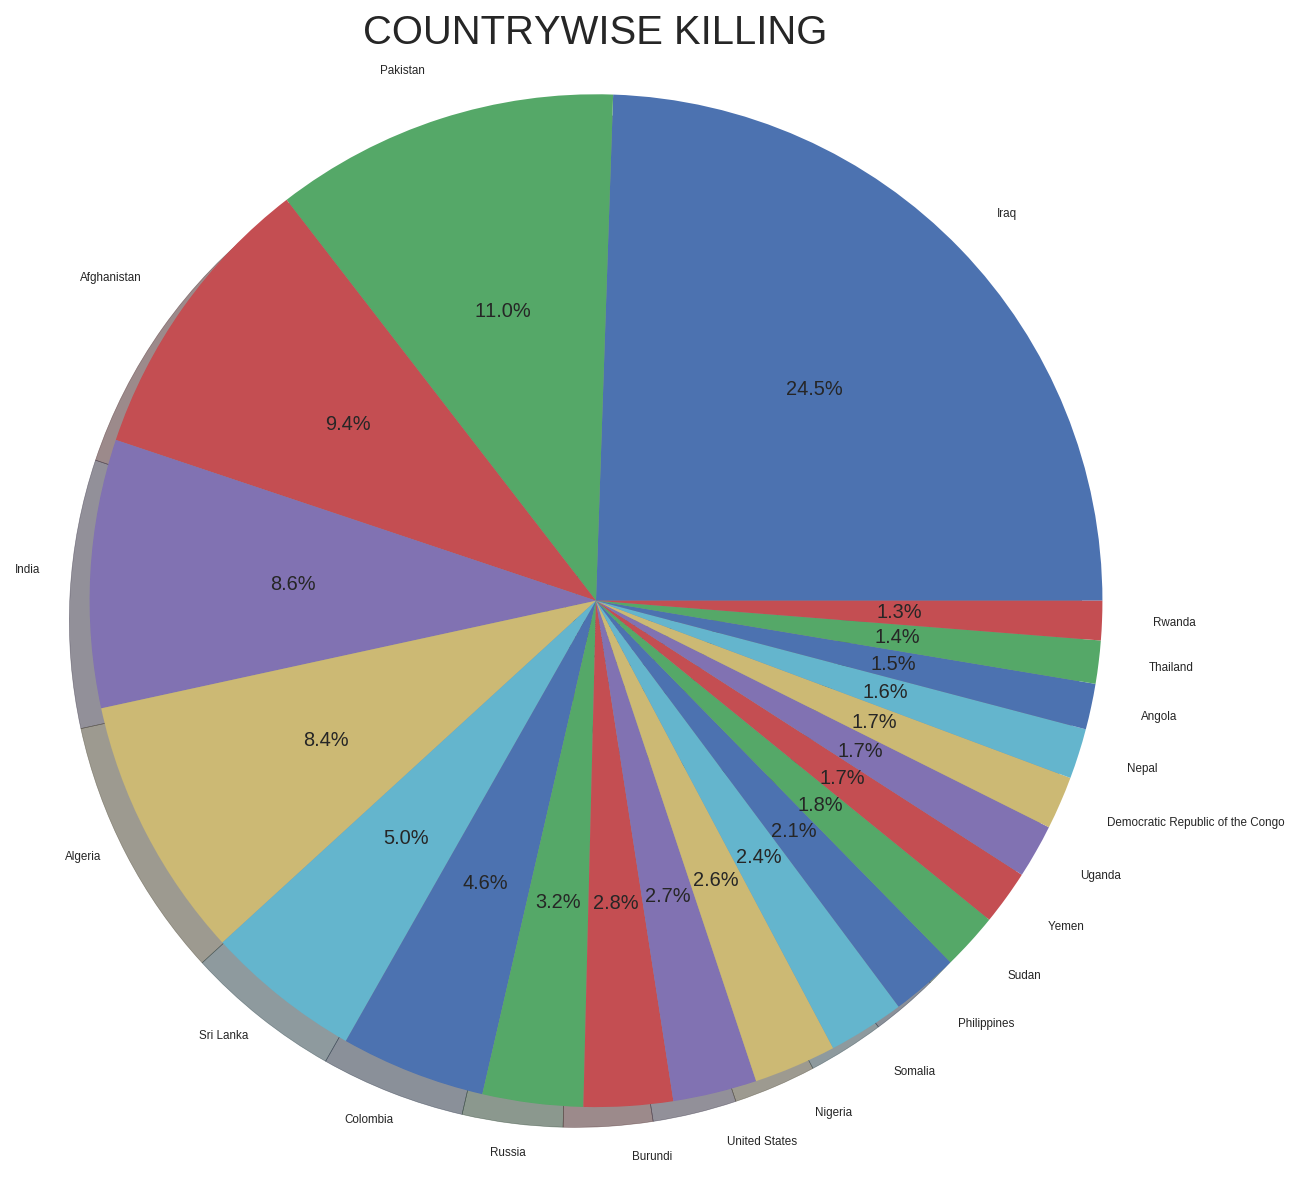

In [236]:
plt.figure(figsize=(10,10))
plt.pie(num_killed_list, labels=corresponding_countries_list, autopct='%1.1f%%', shadow=True)
plt.axis('equal')
plt.title('COUNTRYWISE KILLING', fontsize=20)
plt.show()

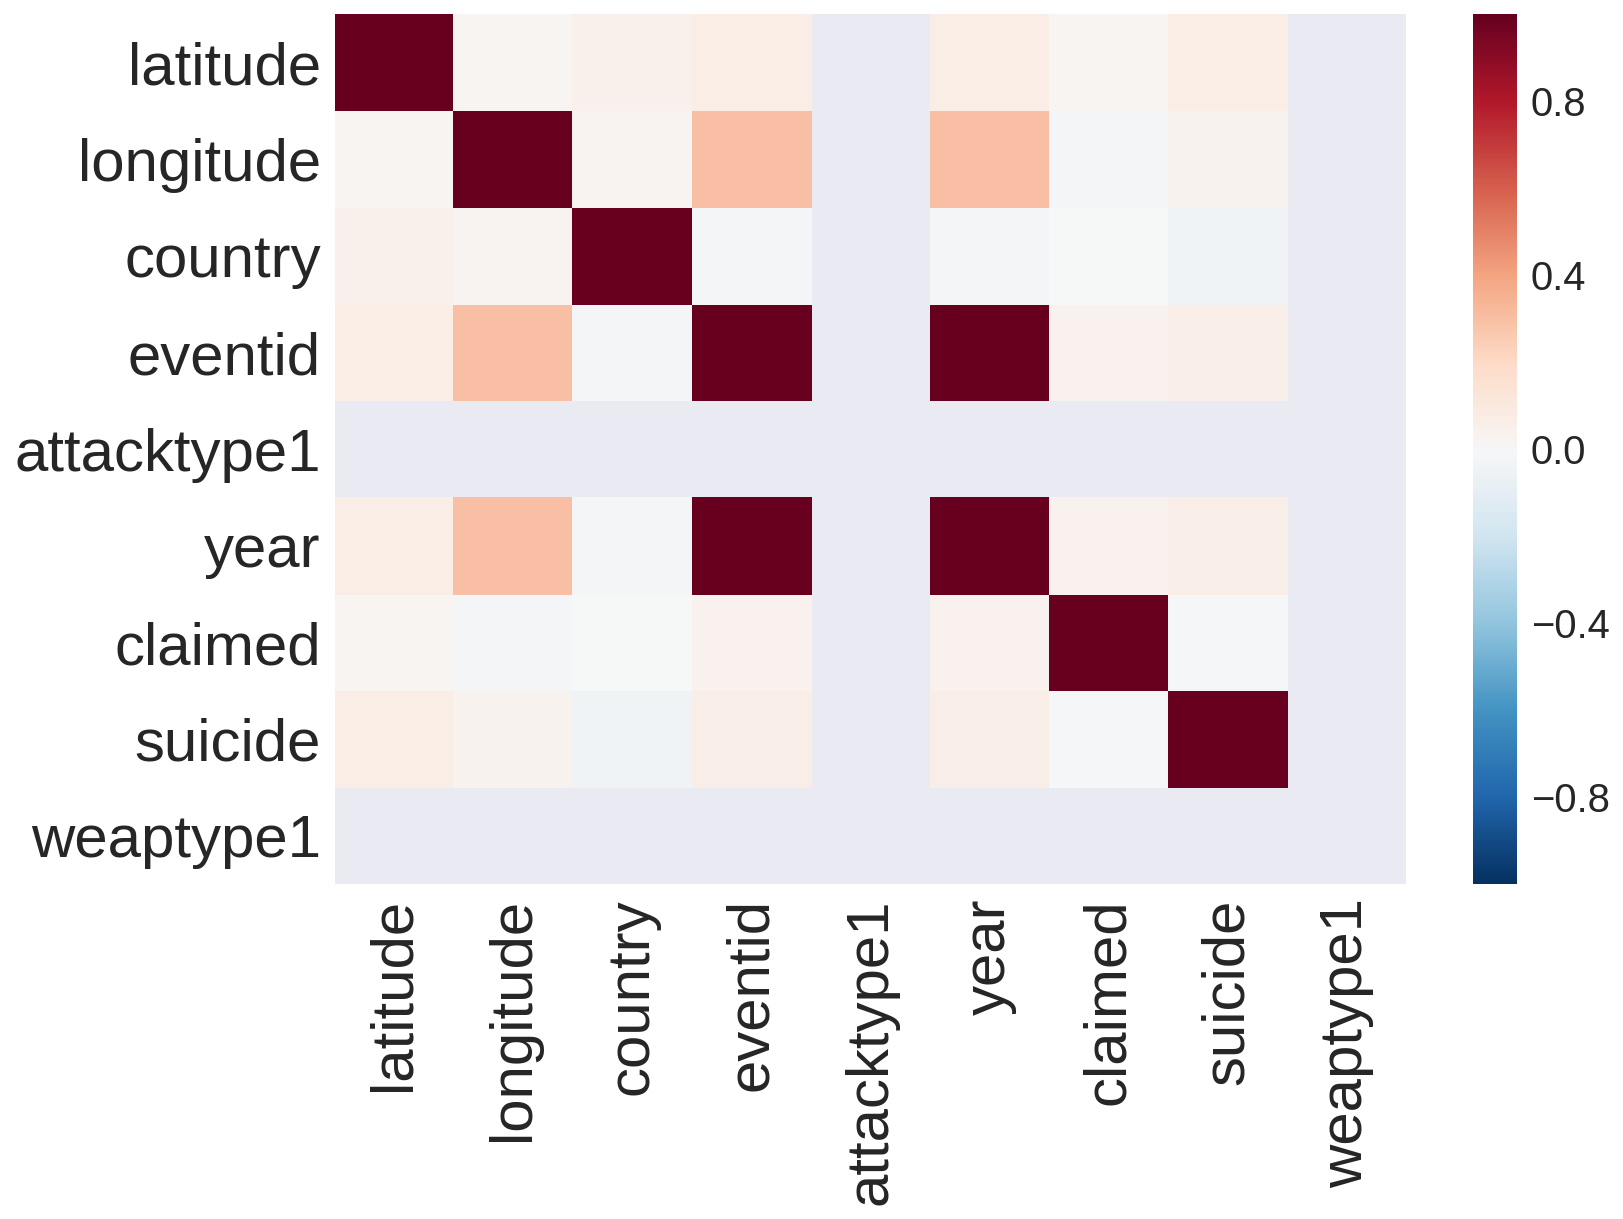

In [238]:
tmp_df = pd.DataFrame(data_frame, columns={'eventid', 'year', 'country', 'longitude', 'latitude', 'claimed', 'suicide',
                                   'attacktype1', 'weaptype1'})
fig, ax = plt.subplots(figsize=(12,8))
sns.set_context("notebook", font_scale=2, rc={"lines.linewidth": 1.0})
ax = sns.heatmap(tmp_df.corr(), cbar=True, ax=ax)
plt.show()

Since no two columns in the heatmap above (except iyear and eventid => eventid are generated with iyear, should also have correlation with imonth and iday) are realted to each other with strong correlation, all of them are important to consider ahead. The correlation between the attacktype and weaptype is also obvious as the attacktype is basically determined based on the weapontype used by the group in the incident.

In [239]:
# Total number of incidents without claim: not 0 or 1 value, something else

original_length = len(df)
length = len(df.loc[df['claimed'].isin({0,1})])
print("Without claim incidents: ", original_length - length)

Without claim incidents:  10695


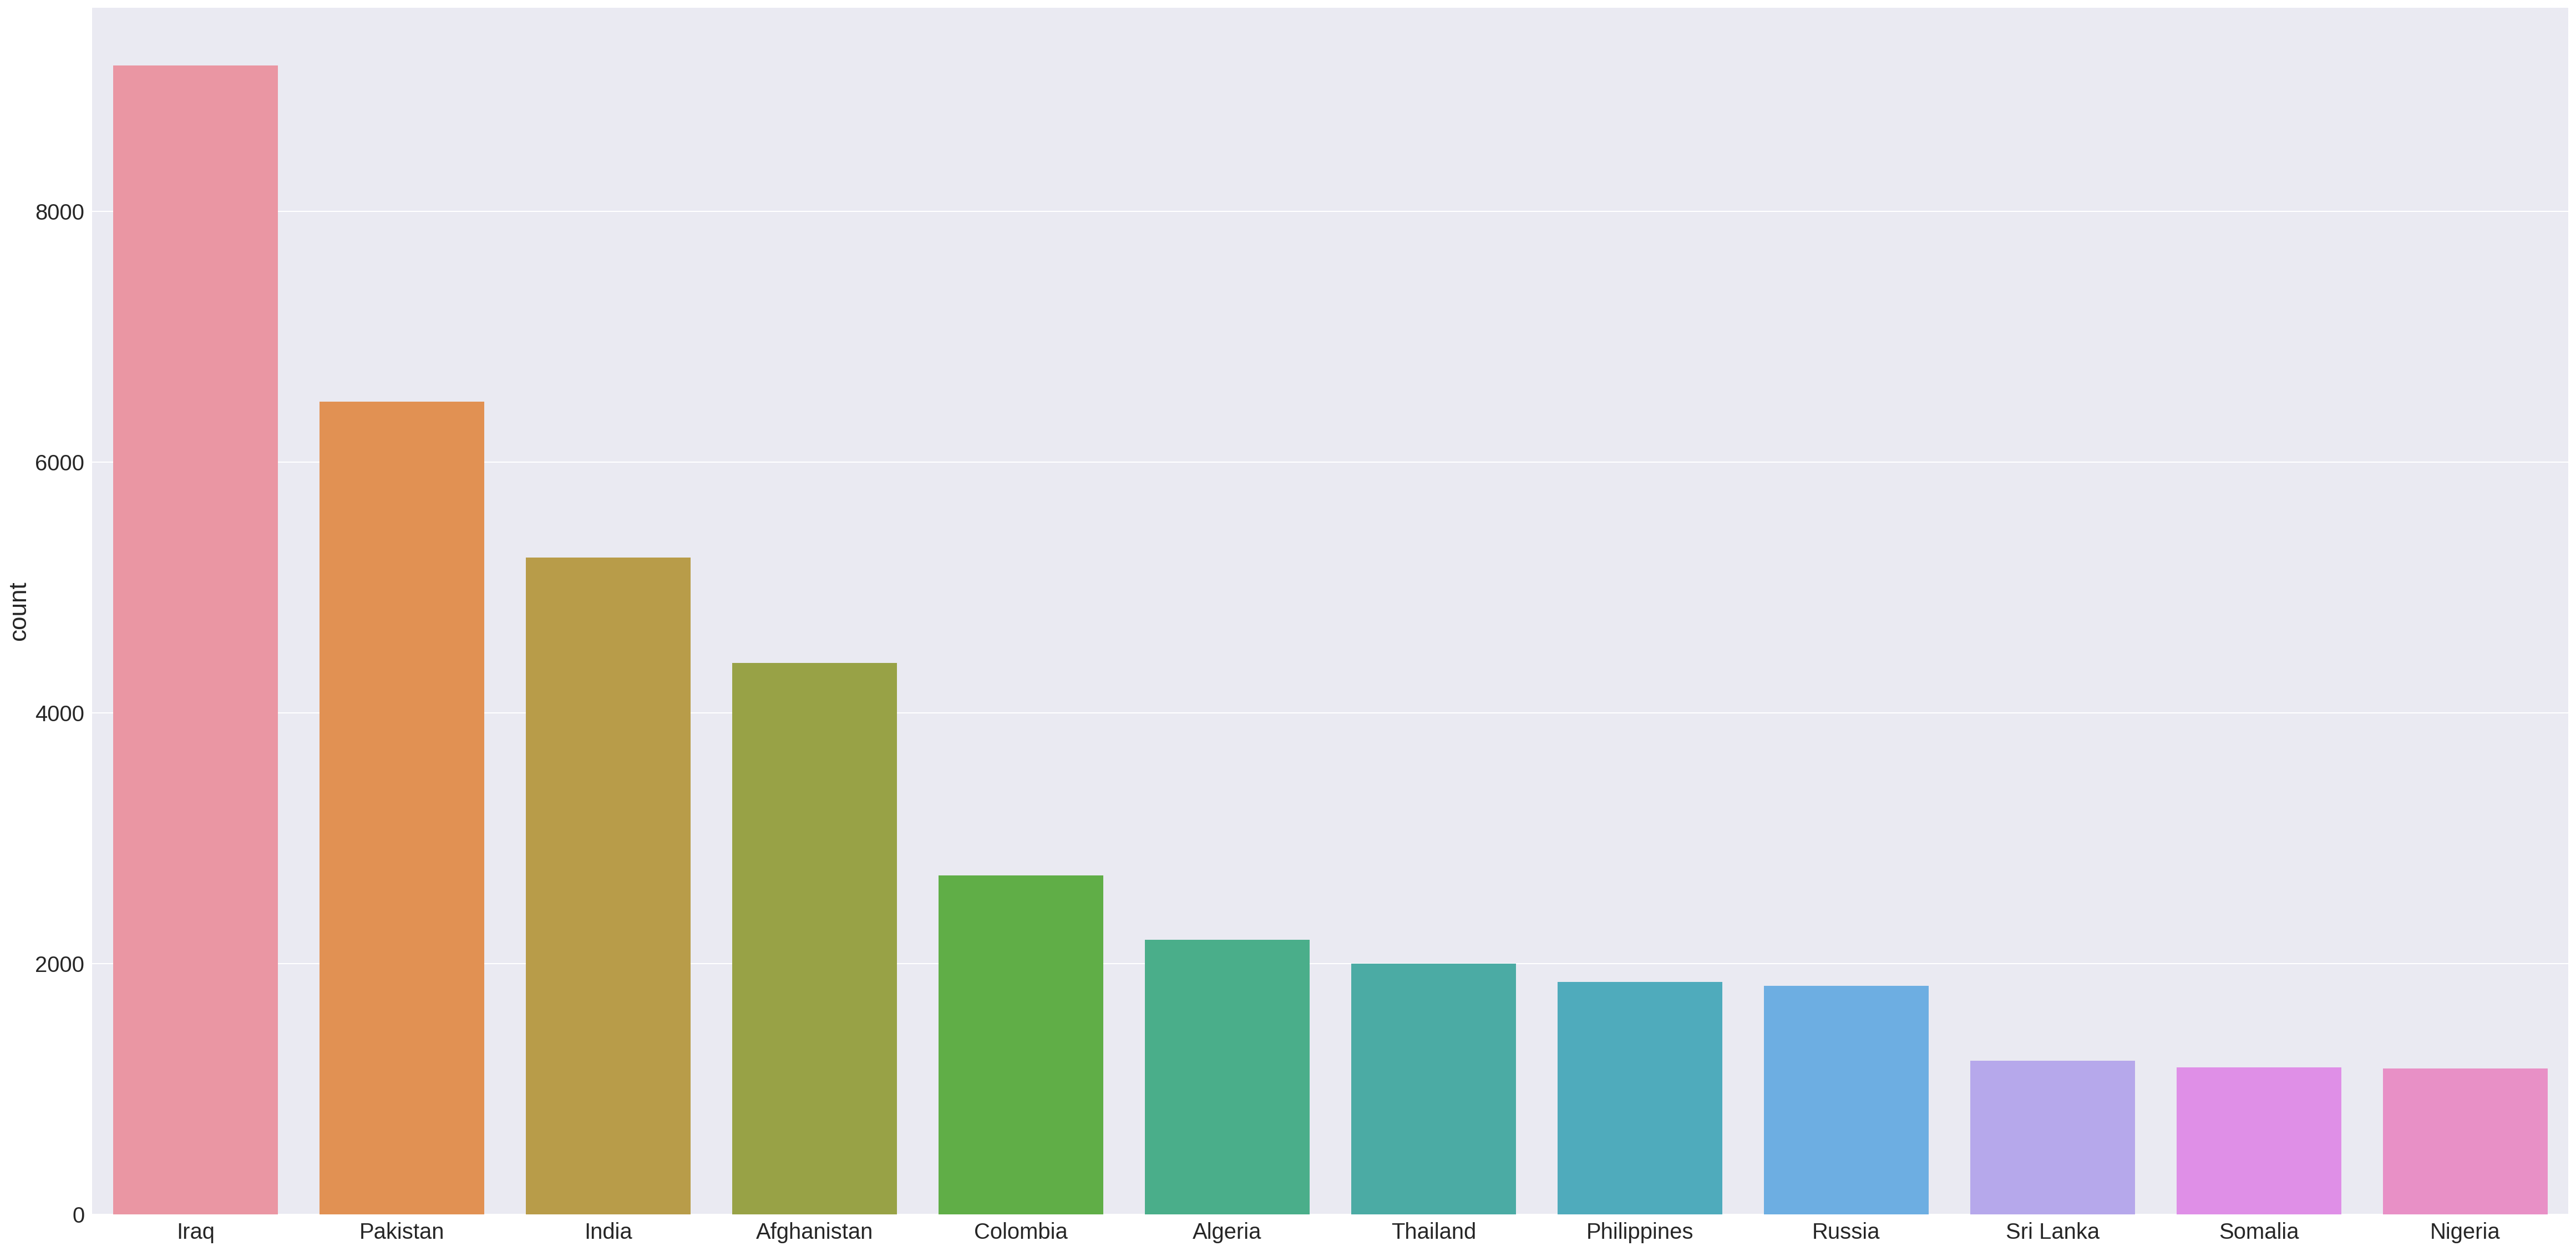

In [240]:
# Plotting the bar diagrams of countries with most incidents
country_list = data_frame['country_txt']
incident_country = country_list.value_counts()

my_dict = dict(incident_country)
new_dict = {}
for key in my_dict.keys():
    if my_dict[key] > 1000:
        new_dict.update({key : my_dict[key]})

countries_with_high_incidents = list(new_dict.keys())
num_incidents = list(new_dict.values())
my_list = []
for i in range(len(countries_with_high_incidents)):
    for j in range(num_incidents[i]):
        my_list.append(countries_with_high_incidents[i])

# Plotting the number of incidents in countries with most incidents
fig, ax = plt.subplots(figsize=(40,20)) 
sns.set(style='darkgrid')
sns.set_context("notebook", font_scale=4, rc={"lines.linewidth": 1.5})
ax = sns.countplot(my_list)
plt.show()

In [241]:
data_frame.columns

Index(['country', 'country_txt', 'eventid', 'year', 'nwound', 'nkillus',
       'provstate', 'suicide', 'nkillter', 'crit1', 'city', 'success',
       'region_txt', 'targtype1_txt', 'nwoundte', 'weaptype1_txt', 'month',
       'claimed', 'date', 'nkill', 'attacktype1_txt', 'latitude', 'longitude',
       'summary', 'motive', 'nwoundus', 'gname', 'day'],
      dtype='object')

### Number of Incidents by Year

In [242]:
# reindexing the data_frame
data_frame.index = range(len(data_frame))
# filling NaN in nkill by 0
data_frame['nkill'] = data_frame['nkill'].fillna(0)

In [243]:
years = data_frame['year'].unique()
# create a dictionary to store year and numbers of people killed in the year
year_killed = dict()
# initializing the dictionary
for year in years:
    year_killed[str(year)] = 0 

In [244]:
# running through the years
for year in years:
    for i in range(len(data_frame)):
        if data_frame['year'].loc[i] == year:
            year_killed[str(year)] += data_frame['nkill'].loc[i]

In [245]:
events_year = dict(data_frame['year'].value_counts())
tmp_df = pd.DataFrame()
tmp_df['year'] = events_year.keys()
tmp_df['events_num'] = events_year.values()
tmp_df.sort_values('year', ascending=True, inplace=True)

In [246]:
# adding number of people killed each year column in the tmp_df
tmp_df['killed'] = year_killed.values()
tmp_df.head()

,year,events_num,killed
7,1995,3081,6094.0
8,1996,3056,6965.0
6,1997,3200,10928.0
17,1998,933,4688.0
13,1999,1395,3388.0


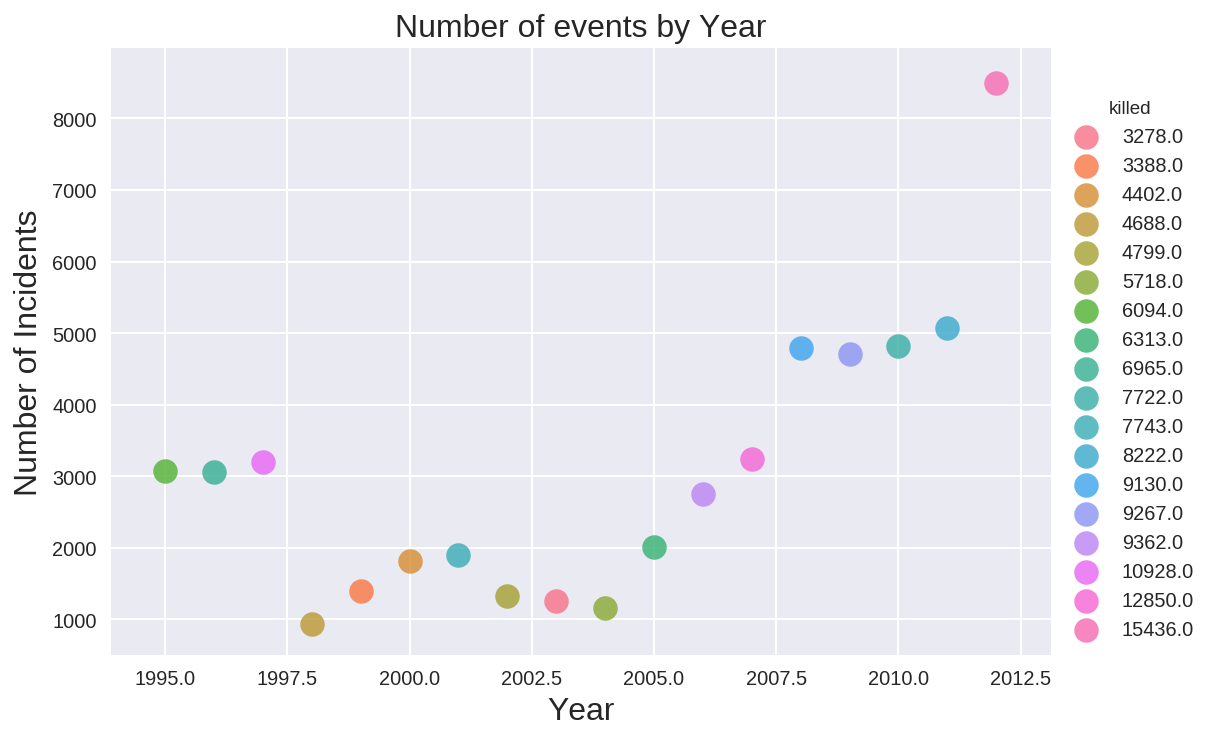

In [247]:
# Create scatterplot of dataframe
sns.set()
plt.figure(figsize=(12,6))
ax = sns.lmplot('year', 'events_num', data=tmp_df, hue='killed', fit_reg=False, 
                scatter_kws={"marker": "0", "s": 150}, aspect=1.5)
plt.title('Number of events by Year', fontsize=16)
plt.ylabel('Number of Incidents', fontsize=16)
plt.xlabel('Year', fontsize=16)
plt.show()

<font size = '14', color='red'>
Prediction Models
</font>

- predicting the associated group ('gname') in an incident based on other information.

In [334]:
# sklearn methods

from sklearn.linear_model import SGDClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import mean_squared_error
from sklearn.ensemble import GradientBoostingClassifier

from sklearn import svm

from sklearn.model_selection import cross_val_score

In [274]:
interesting_columns = {'country', 'longitude', 'latitude', 'claimed', 'suicide','attacktype1_txt',  
                      'targtype1_txt', 'weaptype1_txt', 'gname'}
train_df = pd.DataFrame(data_frame, columns=interesting_columns)
# removing all the NaN values if still anywhere in the data
train_df.dropna(inplace=True)
train_df.index = range(len(train_df))
# the preview of current dataframe
train_df.head()

,attacktype1_txt,longitude,country,latitude,weaptype1_txt,gname,claimed,suicide,targtype1_txt
0,Facility/Infrastructure Attack,-106.648639,217,35.084180,Incendiary,Anti-Abortion extremists,0.0,0,Abortion Related
1,Facility/Infrastructure Attack,-106.648639,217,35.084180,Incendiary,Anti-Abortion extremists,0.0,0,Abortion Related
2,Facility/Infrastructure Attack,-106.648639,217,35.084180,Incendiary,Anti-Abortion extremists,0.0,0,Abortion Related
3,Assassination,68.780000,202,38.536667,Chemical,Unknown,0.0,0,Military
4,Bombing/Explosion,28.950672,209,41.013517,Explosives/Bombs/Dynamite,Unknown,0.0,0,Religious Figures/Institutions


In [275]:
y_train, y_index = pd.factorize(train_df['gname'])
y_train.shape, y_index.shape

((54022,), (1319,))

In [276]:
# training X matrix - without target variable: 'gname'
x_train = pd.get_dummies(train_df.drop('gname', axis=1))
x_train.shape

(54022, 48)

In [277]:
# Data preparation for the model input : into list

x_train_array = np.array([x_train.iloc[i].tolist() for i in range(len(x_train))])
y_train_array = y_train

<font size='5', color='blue' >
Random Forrest Classifier
</font>

In [278]:
# Random Forest Classifier 

rfc = RandomForestClassifier()
rfc.fit(x_train_array[:52000], y_train_array[:52000])

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_split=1e-07, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            n_estimators=10, n_jobs=1, oob_score=False, random_state=None,
            verbose=0, warm_start=False)

In [279]:
rfc.predict(x_train_array[52000:])

array([ 1, 23, 23, ...,  1,  1,  1])

In [280]:
predicted = rfc.predict(x_train_array[52000:])

array([ 1, 23, 23, ...,  1,  1,  1])

In [312]:
rfc.score(x_train_array[52000:], y_train_array[52000:])

0.73986152324431254

In [309]:
actual = list(train_df['gname'][52000:])
predicted_index = [y_index[i] for i in predicted]

In [311]:
# Let us look at few predictions and corresponding actual group names
for i in range(1000, 1010):
    print("Predicted: ", predicted_index[i], "\tand", "Actual: ", actual[i])

Predicted:  Garo National Liberation Army 	and Actual:  Garo National Liberation Army
Predicted:  Unknown 	and Actual:  Unknown
Predicted:  Unknown 	and Actual:  Unknown
Predicted:  Taliban 	and Actual:  Unknown
Predicted:  Unknown 	and Actual:  Unknown
Predicted:  Unknown 	and Actual:  Unknown
Predicted:  Unknown 	and Actual:  Unknown
Predicted:  Communist Party of India - Maoist (CPI-Maoist) 	and Actual:  Unknown
Predicted:  New People's Army (NPA) 	and Actual:  New People's Army (NPA)
Predicted:  Unknown 	and Actual:  Taliban


In [313]:
# Looking into the most important features in the train data

max_importance = rfc.feature_importances_.max()
print("Maximum feature importance value: ", max_importance)
print('')

print('feature', '\t', 'feature_importance')
for index, value in enumerate(rfc.feature_importances_):
    
    # printing the most important features
    if value > 0.01:
        print(x_train.columns[index], '\t', value)

Maximum feature importance value:  0.322680166316

feature 	 feature_importance
longitude 	 0.322680166316
country 	 0.136424090402
latitude 	 0.288865076436
claimed 	 0.0876376970085
targtype1_txt_Private Citizens & Property 	 0.0125246919186


Hmm.... 'latitude' and  'longitude' are the most important features! Country seems also important which is already a redundant with geographical coordinates.

- I am including country (even the same numerical indexing followed in the data manual) in the training. It is not a preferred way to do for sure. But I am still including it just because it slightly increased the accuracy.

In [315]:
# Mean accuracy of the prediction: 
# accuracy of predict(x_train_list[50000:]) with respect to y_train_list[50000:]

rfc.score(x_train_array[52000:], y_train_array[52000:])

0.73986152324431254

In [316]:
scores = cross_val_score(rfc, x_train_array[52000:55000], y_train_array[52000:55000])
print(scores, 'and mean value: ', scores.mean())

[ 0.73044693  0.73453997  0.75116641] and mean value:  0.738717768224


/home/rabindra/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:581: Warning: The least populated class in y has only 1 members, which is too few. The minimum number of groups for any class cannot be less than n_splits=3.
  % (min_groups, self.n_splits)), Warning)


In [317]:
rfc.decision_path(x_train_array[52000:])

(<2022x252864 sparse matrix of type '<class 'numpy.int64'>'
 	with 506642 stored elements in Compressed Sparse Row format>,
 array([     0,  24901,  50244,  75439, 100848, 125921, 151290, 176713,
        202888, 227655, 252864]))

<font size='5', color='blue' >
Support Vector Machines Classifier
</font>

In [337]:
clf = svm.SVC()
clf.fit(x_train_array[:52000], y_train_array[:52000])

SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape=None, degree=3, gamma='auto', kernel='rbf',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False)

In [338]:
clf.predict(x_train_array[52000:])

array([ 1, 23, 23, ...,  1,  1,  1])

In [367]:
clf.score(x_train_array[52000:], y_train_array[52000:])

0.75618199802176067

Better than the Random Forest Classifier for this case!

In [368]:
cross_val_scores_val_scores_val_score(clf, x_train_array[52000:], y_train_array[52000:])

/home/rabindra/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:581: Warning: The least populated class in y has only 1 members, which is too few. The minimum number of groups for any class cannot be less than n_splits=3.
  % (min_groups, self.n_splits)), Warning)


array([ 0.66340782,  0.72850679,  0.74494557])

In [369]:
clf.support_vectors_

array([[-106.648639,  217.      ,   35.08418 , ...,    0.      ,
           0.      ,    0.      ],
       [-122.891429,  217.      ,   47.039225, ...,    0.      ,
           0.      ,    0.      ],
       [-123.334877,  217.      ,   42.348135, ...,    0.      ,
           0.      ,    0.      ],
       ..., 
       [ 101.6175  ,  205.      ,    6.701389, ...,    0.      ,
           0.      ,    0.      ],
       [ 101.6175  ,  205.      ,    6.701389, ...,    0.      ,
           0.      ,    0.      ],
       [  36.3064  ,  200.      ,   33.5111  , ...,    0.      ,
           0.      ,    0.      ]])

In [370]:
clf.support_

array([   21,    58,   120, ..., 51793, 51803, 51888], dtype=int32)

In [371]:
clf.n_support_

array([   54, 14786,    18, ...,     1,     2,     1], dtype=int32)

In [372]:
print(__doc__)

Automatically created module for IPython interactive environment
